<a href="https://colab.research.google.com/github/d61h6k4/notebooks/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets matplotlib numpy
!pip install tensorflow-gpu==2.0.0-rc0
!pip install scikit-learn

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


import sklearn.metrics as sk_metrics
from sklearn.utils.multiclass import unique_labels

In [0]:
class Block(tf.keras.layers.Layer):
    def __init__(self, filters, strides, name, high_with_conv=False):
        super(Block, self).__init__(name)
        self.bn0 = tf.keras.layers.BatchNormalization()
        self.relu0 = tf.keras.layers.ReLU()
        self.conv0 = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)
        self.add0 = tf.keras.layers.Add()
        
        self.high_with_conv = high_with_conv
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False)
        
    def __call__(self, inputs, training=False):
        prep_xs = self.bn0(inputs)
        prep_xs = self.relu0(prep_xs)
        
        if self.high_with_conv:
            high_way_xs = self.conv2(prep_xs)
        else:
            high_way_xs = prep_xs
            
        low_way_xs = self.conv0(prep_xs)
        low_way_xs = self.bn1(low_way_xs)
        low_way_xs = self.relu1(low_way_xs)
        low_way_xs = self.conv1(low_way_xs)
        
        return self.add0([high_way_xs, low_way_xs])

In [0]:
class DAWNNet(tf.keras.Model):
    def __init__(self):
        super(DAWNNet, self).__init__()
        self.__prep = tf.keras.Sequential(layers=[
            tf.keras.layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False)
        ], name='prep')
        self.__first_layer = tf.keras.Sequential(layers=[
            Block(64, 1, name='first_simple_block'),
            Block(64, 1, name='second_simple_block'),
        ], name='layer_1')
        self.__second_layer = tf.keras.Sequential(layers=[
            Block(128, 2, name='first_with_conv_block', high_with_conv=True),
            Block(128, 1, name='second_simple_block')
        ], name='layer_2')
        self.__third_layer = tf.keras.Sequential(layers=[
            Block(256, 2, name='first_with_conv_block', high_with_conv=True),
            Block(256, 1, name='second_simple_block')
        ], name='layer_3')
        self.__fourth_layer = tf.keras.Sequential(layers=[
            Block(256, 2, name='first_with_conv_block', high_with_conv=True),
            Block(256, 1, name='second_simple_block')
        ], name='layer_4')
        self.__final = tf.keras.Sequential(layers=[
            tf.keras.layers.MaxPool2D(4),
            tf.keras.layers.Flatten()
        ], name='pool')
        self.__classifier = tf.keras.layers.Dense(10, activation='softmax', name='classifier')
        
    def __call__(self, inputs, training=False):
        prepeared_images = self.__prep(inputs, training)
        images = self.__first_layer(prepeared_images, training)
        images = self.__second_layer(images, training)
        images = self.__third_layer(images, training)
        images = self.__fourth_layer(images, training)
        finalized_images = self.__final(images, training)
        images_classes = self.__classifier(finalized_images)
        
        return images_classes

In [0]:
def preprocess_image(example):
    example['image'] = tf.image.transpose(
        tf.image.per_image_standardization(
            tf.pad(tf.cast(example['image'], tf.float32), tf.constant([[4, 4], [4, 4], [0, 0]]), "REFLECT")))
    return example


def augmentation(example):
    image = tf.image.random_crop(example['image'], [32, 32, 3])
    image = tf.image.random_flip_left_right(image)
    
    return {'image': image, 'label': example['label']}

In [8]:
train = tfds.load(name='cifar10', split='train')
train = train.map(preprocess_image).map(augmentation).shuffle(buffer_size=10240).batch(128)

W0828 17:34:02.166037 140079652231040 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [0]:
model = DAWNNet()

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
optimizer = tf.compat.v2.train.experimental.enable_mixed_precision_graph_rewrite(optimizer)

for epoch in range(15):
    for step, example in enumerate(train):
        with tf.GradientTape() as tape:
            logits = model(example['image'], training=True)
            loss = loss_fn(example['label'], logits)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        if step % 100 == 0:
            print(epoch, step, float(loss))

W0828 17:34:12.554577 140079652231040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 0 4.008696556091309
0 100 1.8902342319488525
0 200 1.5365568399429321
0 300 1.4908180236816406
1 0 1.7883570194244385
1 100 1.569170355796814
1 200 1.3856981992721558
1 300 1.3105393648147583
2 0 1.230039358139038
2 100 1.3544955253601074
2 200 1.0862064361572266
2 300 0.9188615083694458
3 0 1.0411462783813477
3 100 0.9829086065292358
3 200 0.9602609872817993
3 300 0.9190474152565002
4 0 1.0094987154006958
4 100 0.8199965953826904
4 200 0.8116742372512817
4 300 0.7691331505775452
5 0 0.8014827966690063
5 100 0.8717688918113708
5 200 0.6322211027145386
5 300 0.6393815875053406
6 0 0.7117184400558472
6 100 0.6289150714874268
6 200 0.7396141886711121
6 300 0.8026283383369446
7 0 0.5717959403991699
7 100 0.6794004440307617
7 200 0.5936603546142578
7 300 0.5936791300773621
8 0 0.5648244023323059
8 100 0.6005518436431885
8 200 0.5202226638793945
8 300 0.583609938621521
9 0 0.5515555739402771
9 100 0.584266185760498
9 200 0.61482173204422
9 300 0.5263940095901489
10 0 0.4105752408504486
10 

In [0]:
test = tfds.load(name='cifar10', split='test').map(preprocess_image).shuffle(buffer_size=1024).batch(128)

y_true = []
y_pred = []
for example in test:
    pred = model(example['image'])
    y_true.extend(example['label'].numpy())
    y_pred.extend(np.argmax(pred.numpy(), axis=1))
    
y_test = np.array(y_true)
y_pred = np.array(y_pred)

Confusion matrix, without normalization
Normalized confusion matrix


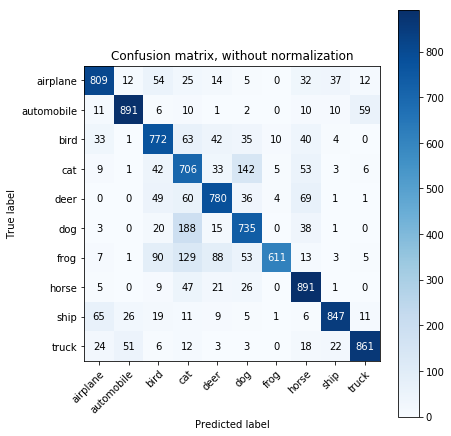

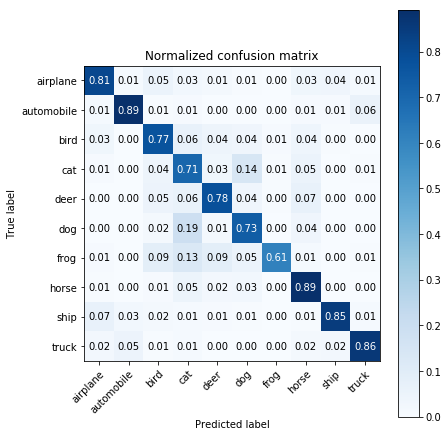

In [12]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']
classes = class_names

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sk_metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(6.5, 6.5, forward=True)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [13]:
print(f'Accuracy equal to {sk_metrics.accuracy_score(y_true, y_pred)}')

Accuracy equal to 0.7903
